In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.sparse import diags, csr_matrix, eye, tril
from scipy.sparse.linalg import gmres, LinearOperator, spsolve_triangular
import time
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable, Optional, Dict
import warnings
import pandas as pd
from preconditioners import JacobiPreconditioner, BlockJacobiPreconditioner, SORPreconditioner
from solver import standard_gmres, deflated_gmres_no_precond, standard_gmres_with_precond, deflated_gmres_precond_before, deflated_gmres_precond_after
from model import load_model
from data.data_work import extract_params_from_data, poisson_rhs_manufactured, build_matrix
warnings.filterwarnings('ignore')


def test_all_methods(A: csr_matrix,
                     b: np.ndarray,
                     Y_n: np.ndarray,
                     matrix_idx: int,
                     tol: float = 1e-7,
                     maxiter: int = 5000) -> Dict:
    """
    Test all 11 variants and return results.

    Methods:
    1. Standard GMRES (no precond)
    2-4. Standard GMRES + Jacobi/BlockJacobi/SOR
    5. Deflated GMRES (no precond)
    6-8. Precond → Model → Deflated (Jacobi/BlockJacobi/SOR)
    9-11. Model → Precond → Deflated (Jacobi/BlockJacobi/SOR)
    """
    n = A.shape[0]
    print(f"\nTesting matrix {matrix_idx} (size {n}×{n})")
    print("="*70)

    # Create preconditioners
    block_size = min(300, int(np.sqrt(n)))  # Adaptive block size
    preconditioners = {
        'Jacobi': JacobiPreconditioner(A),
        'BlockJacobi': BlockJacobiPreconditioner(A, block_size=block_size),
        'SOR': SORPreconditioner(A, omega=1.0)
    }

    results = {
        'matrix_idx': matrix_idx,
        'matrix_size': n,
        'methods': {}
    }

    # Helper to record iterations
    def make_callback(hist_list):
        def callback(rk):
            hist_list.append(np.linalg.norm(rk) / np.linalg.norm(b))
        return callback

    # ----- GROUP 1: Standard GMRES -----
    print("\n[1/11] Standard GMRES (no precond)...")
    hist = []
    x, info = standard_gmres(A, b, tol=tol, maxiter=maxiter, callback=make_callback(hist))
    info['iterations'] = len(hist)
    info['history'] = np.array(hist)
    results['methods']['Standard'] = info
    baseline_time = info['time']
    baseline_iters = info['iterations']
    print(f"  ✓ {info['iterations']} iters, {info['time']:.3f}s")

    for i, (name, precond) in enumerate(preconditioners.items(), start=2):
        print(f"\n[{i}/11] GMRES + {name}...")
        hist = []
        x, info = standard_gmres_with_precond(A, b, precond, tol=tol,
                                               maxiter=maxiter, callback=make_callback(hist))
        info['iterations'] = len(hist)
        info['history'] = np.array(hist)
        results['methods'][f'Standard+{name}'] = info
        print(f"  ✓ {info['iterations']} iters, {info['time']:.3f}s")

    # ----- GROUP 2: Deflated without precond -----
    print(f"\n[5/11] Deflated GMRES (no precond)...")
    hist = []
    x, info = deflated_gmres_no_precond(A, b, Y_n, tol=tol, maxiter=maxiter,
                                         callback=make_callback(hist))
    info['iterations'] = len(hist)
    info['history'] = np.array(hist)
    results['methods']['Deflated'] = info
    print(f"  ✓ {info['iterations']} iters, {info['time']:.3f}s")

    # ----- GROUP 3: Precond BEFORE model -----
    for i, (name, precond) in enumerate(preconditioners.items(), start=6):
        print(f"\n[{i}/11] {name} → Model → Deflated...")
        hist = []
        x, info = deflated_gmres_precond_before(A, b, Y_n, precond, tol=tol,
                                                 maxiter=maxiter, callback=make_callback(hist))
        info['iterations'] = len(hist)
        info['history'] = np.array(hist)
        results['methods'][f'{name}→Model→Deflated'] = info
        print(f"  ✓ {info['iterations']} iters, {info['time']:.3f}s")

    # ----- GROUP 4: Precond AFTER model -----
    for i, (name, precond) in enumerate(preconditioners.items(), start=9):
        print(f"\n[{i}/11] Model → {name} → Deflated...")
        hist = []
        x, info = deflated_gmres_precond_after(A, b, Y_n, precond, tol=tol,
                                                maxiter=maxiter, callback=make_callback(hist))
        info['iterations'] = len(hist)
        info['history'] = np.array(hist)
        results['methods'][f'Model→{name}→Deflated'] = info
        print(f"  ✓ {info['iterations']} iters, {info['time']:.3f}s")

    # Compute speedups relative to baseline
    for method_name, method_info in results['methods'].items():
        method_info['speedup_time'] = baseline_time / method_info['time']
        method_info['speedup_iters'] = baseline_iters / method_info['iterations']

    print(f"\n{'='*70}")
    print(f"Matrix {matrix_idx} - Summary:")
    print(f"  Baseline: {baseline_iters} iters, {baseline_time:.3f}s")
    for method_name, method_info in results['methods'].items():
        print(f"  {method_name:30s}: {method_info['speedup_time']:.2f}x time, "
              f"{method_info['speedup_iters']:.2f}x iters")

    return results


def visualize_results(results_list: List[Dict], save_path: str = 'results_comparison.png'):
    """Visualize convergence histories."""
    n_tests = len(results_list)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 5*n_tests))

    for test_idx, results in enumerate(results_list):
        # Create 4 subplots for each test matrix

        # Subplot 1: Standard methods
        ax1 = plt.subplot(n_tests, 4, test_idx*4 + 1)
        ax1.set_title(f'Matrix {results["matrix_idx"]}: Standard GMRES', fontsize=12, fontweight='bold')
        for method_name in ['Standard', 'Standard+Jacobi', 'Standard+BlockJacobi', 'Standard+SOR']:
            if method_name in results['methods']:
                info = results['methods'][method_name]
                ax1.semilogy(info['history'], label=method_name, linewidth=2)
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Relative Residual')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)

        # Subplot 2: Deflated vs Standard
        ax2 = plt.subplot(n_tests, 4, test_idx*4 + 2)
        ax2.set_title(f'Matrix {results["matrix_idx"]}: Deflated vs Standard', fontsize=12, fontweight='bold')
        if 'Standard' in results['methods']:
            info = results['methods']['Standard']
            ax2.semilogy(info['history'], label='Standard', linewidth=2, linestyle='--')
        if 'Deflated' in results['methods']:
            info = results['methods']['Deflated']
            ax2.semilogy(info['history'], label='Deflated (no precond)', linewidth=2)
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Relative Residual')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)

        # Subplot 3: Precond BEFORE model
        ax3 = plt.subplot(n_tests, 4, test_idx*4 + 3)
        ax3.set_title(f'Matrix {results["matrix_idx"]}: Precond→Model→Deflated', fontsize=12, fontweight='bold')
        if 'Deflated' in results['methods']:
            info = results['methods']['Deflated']
            ax3.semilogy(info['history'], label='Deflated (no precond)',
                        linewidth=2, linestyle='--', color='black')
        for precond in ['Jacobi', 'BlockJacobi', 'SOR']:
            method_name = f'{precond}→Model→Deflated'
            if method_name in results['methods']:
                info = results['methods'][method_name]
                ax3.semilogy(info['history'], label=method_name, linewidth=2)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Relative Residual')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)

        # Subplot 4: Precond AFTER model
        ax4 = plt.subplot(n_tests, 4, test_idx*4 + 4)
        ax4.set_title(f'Matrix {results["matrix_idx"]}: Model→Precond→Deflated', fontsize=12, fontweight='bold')
        if 'Deflated' in results['methods']:
            info = results['methods']['Deflated']
            ax4.semilogy(info['history'], label='Deflated (no precond)',
                        linewidth=2, linestyle='--', color='black')
        for precond in ['Jacobi', 'BlockJacobi', 'SOR']:
            method_name = f'Model→{precond}→Deflated'
            if method_name in results['methods']:
                info = results['methods'][method_name]
                ax4.semilogy(info['history'], label=method_name, linewidth=2)
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Relative Residual')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualization saved to {save_path}")
    plt.show()


def save_results_to_csv(results_list: List[Dict], save_path: str = 'results.csv'):
    """Save all results to CSV."""
    rows = []
    for results in results_list:
        matrix_idx = results['matrix_idx']
        matrix_size = results['matrix_size']

        for method_name, method_info in results['methods'].items():
            rows.append({
                'matrix_idx': matrix_idx,
                'matrix_size': matrix_size,
                'method': method_name,
                'iterations': method_info['iterations'],
                'time': method_info['time'],
                'speedup_time': method_info['speedup_time'],
                'speedup_iters': method_info['speedup_iters'],
                'exit_code': method_info['exit_code']
            })

    df = pd.DataFrame(rows)
    df.to_csv(save_path, index=False)
    print(f"✓ Results saved to {save_path}")

    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)

    summary = df.groupby('method').agg({
        'speedup_time': ['mean', 'std', 'min', 'max'],
        'speedup_iters': ['mean', 'std', 'min', 'max'],
        'time': ['mean', 'std'],
        'iterations': ['mean', 'std']
    }).round(3)

    print(summary)


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main_pipeline(data_path: str,
                  model_path: str,
                  num_tests: int = 5,
                  tol: float = 1e-7,
                  maxiter: int = 5000,
                  device: str = 'cuda'):
    """
    Main testing pipeline.

    Parameters:
    -----------
    data_path : str - path to test data (.pt file)
    model_path : str - path to trained model
    num_tests : int - number of matrices to test
    tol : float - GMRES tolerance
    maxiter : int - GMRES max iterations
    device : str - 'cuda' or 'cpu'
    """
    print("="*70)
    print("DEFLATED GMRES WITH PRECONDITIONERS - FULL TESTING PIPELINE")
    print("="*70)

    print(f"\nConfiguration:")
    print(f"  Data: {data_path}")
    print(f"  Model: {model_path}")
    print(f"  Device: {device}")
    print(f"  Num tests: {num_tests}")
    print(f"  GMRES tol: {tol}, maxiter: {maxiter}")

    # Load data
    print(f"\nLoading test data...")
    test_data = torch.load(data_path)
    params = test_data['params']
    print(f"  ✓ Loaded {params.shape[0]} test samples")

    # Load model
    print(f"\nLoading trained model...")
    model = load_model(model_path, device=device)
    print(f"  ✓ Model loaded successfully")

    # Select test matrices
    np.random.seed(42)
    test_indices = np.random.choice(params.shape[0], size=num_tests, replace=False)
    print(f"\nSelected test matrices: {test_indices}")

    # Test all matrices
    results_list = []

    for test_idx in test_indices:
        print(f"\n{'='*70}")
        print(f"TESTING MATRIX {test_idx}")
        print(f"{'='*70}")

        # Build matrix
        param_sample = params[test_idx]
        w, p = extract_params_from_data(param_sample)
        A = build_matrix(w, p)

        # Generate RHS
        s = w.shape[0] - 2
        b = poisson_rhs_manufactured(nx=s, ny=s, scale_with_h=True)

        # Predict subspace
        print("\nPredicting subspace with FNO...")
        with torch.no_grad():
            inputs = param_sample.unsqueeze(0).to(device)
            if inputs.shape[1] == 302:
                inputs = inputs[:, 1:-1, 1:-1, :]

            Q = model(inputs=inputs)
            Y_n = Q[0].cpu().numpy()

        print(f"  ✓ Predicted subspace: {Y_n.shape}")

        # Test all methods
        results = test_all_methods(A, b, Y_n, test_idx, tol=tol, maxiter=maxiter)
        results_list.append(results)

        # Clear memory
        del A, b, Y_n
        torch.cuda.empty_cache()

    # Visualize and save
    print(f"\n{'='*70}")
    print("SAVING RESULTS")
    print(f"{'='*70}")

    visualize_results(results_list, save_path='deflated_precond_comparison.png')
    save_results_to_csv(results_list, save_path='deflated_precond_results.csv')

    print("\n" + "="*70)
    print("TESTING COMPLETE")
    print("="*70)

    return results_list

DEFLATED GMRES WITH PRECONDITIONERS - FULL TESTING PIPELINE

Configuration:
  Data: /content/drive/MyDrive/heat_backup/heat_batch_33.pt
  Model: ./results/base_model.pt
  Device: cuda
  Num tests: 5
  GMRES tol: 1e-07, maxiter: 5000

Loading test data...
  ✓ Loaded 100 test samples

Loading trained model...
  ✓ Model loaded successfully

Selected test matrices: [83 53 70 45 44]

TESTING MATRIX 83

Predicting subspace with FNO...
  ✓ Predicted subspace: (90000, 25)

Testing matrix 83 (size 90000×90000)

[1/11] Standard GMRES (no precond)...
  ✓ 5000 iters, 20.216s

[2/11] GMRES + Jacobi...
  ✓ 4686 iters, 24.208s

[3/11] GMRES + BlockJacobi...
  ✓ 3444 iters, 108.536s

[4/11] GMRES + SOR...
  ✓ 4540 iters, 129.693s

[5/11] Deflated GMRES (no precond)...
  ✓ 2339 iters, 14.447s

[6/11] Jacobi → Model → Deflated...
  ✓ 1457 iters, 10.501s

[7/11] BlockJacobi → Model → Deflated...
  ✓ 659 iters, 23.483s

[8/11] SOR → Model → Deflated...
  ✓ 872 iters, 26.603s

[9/11] Model → Jacobi → Defla

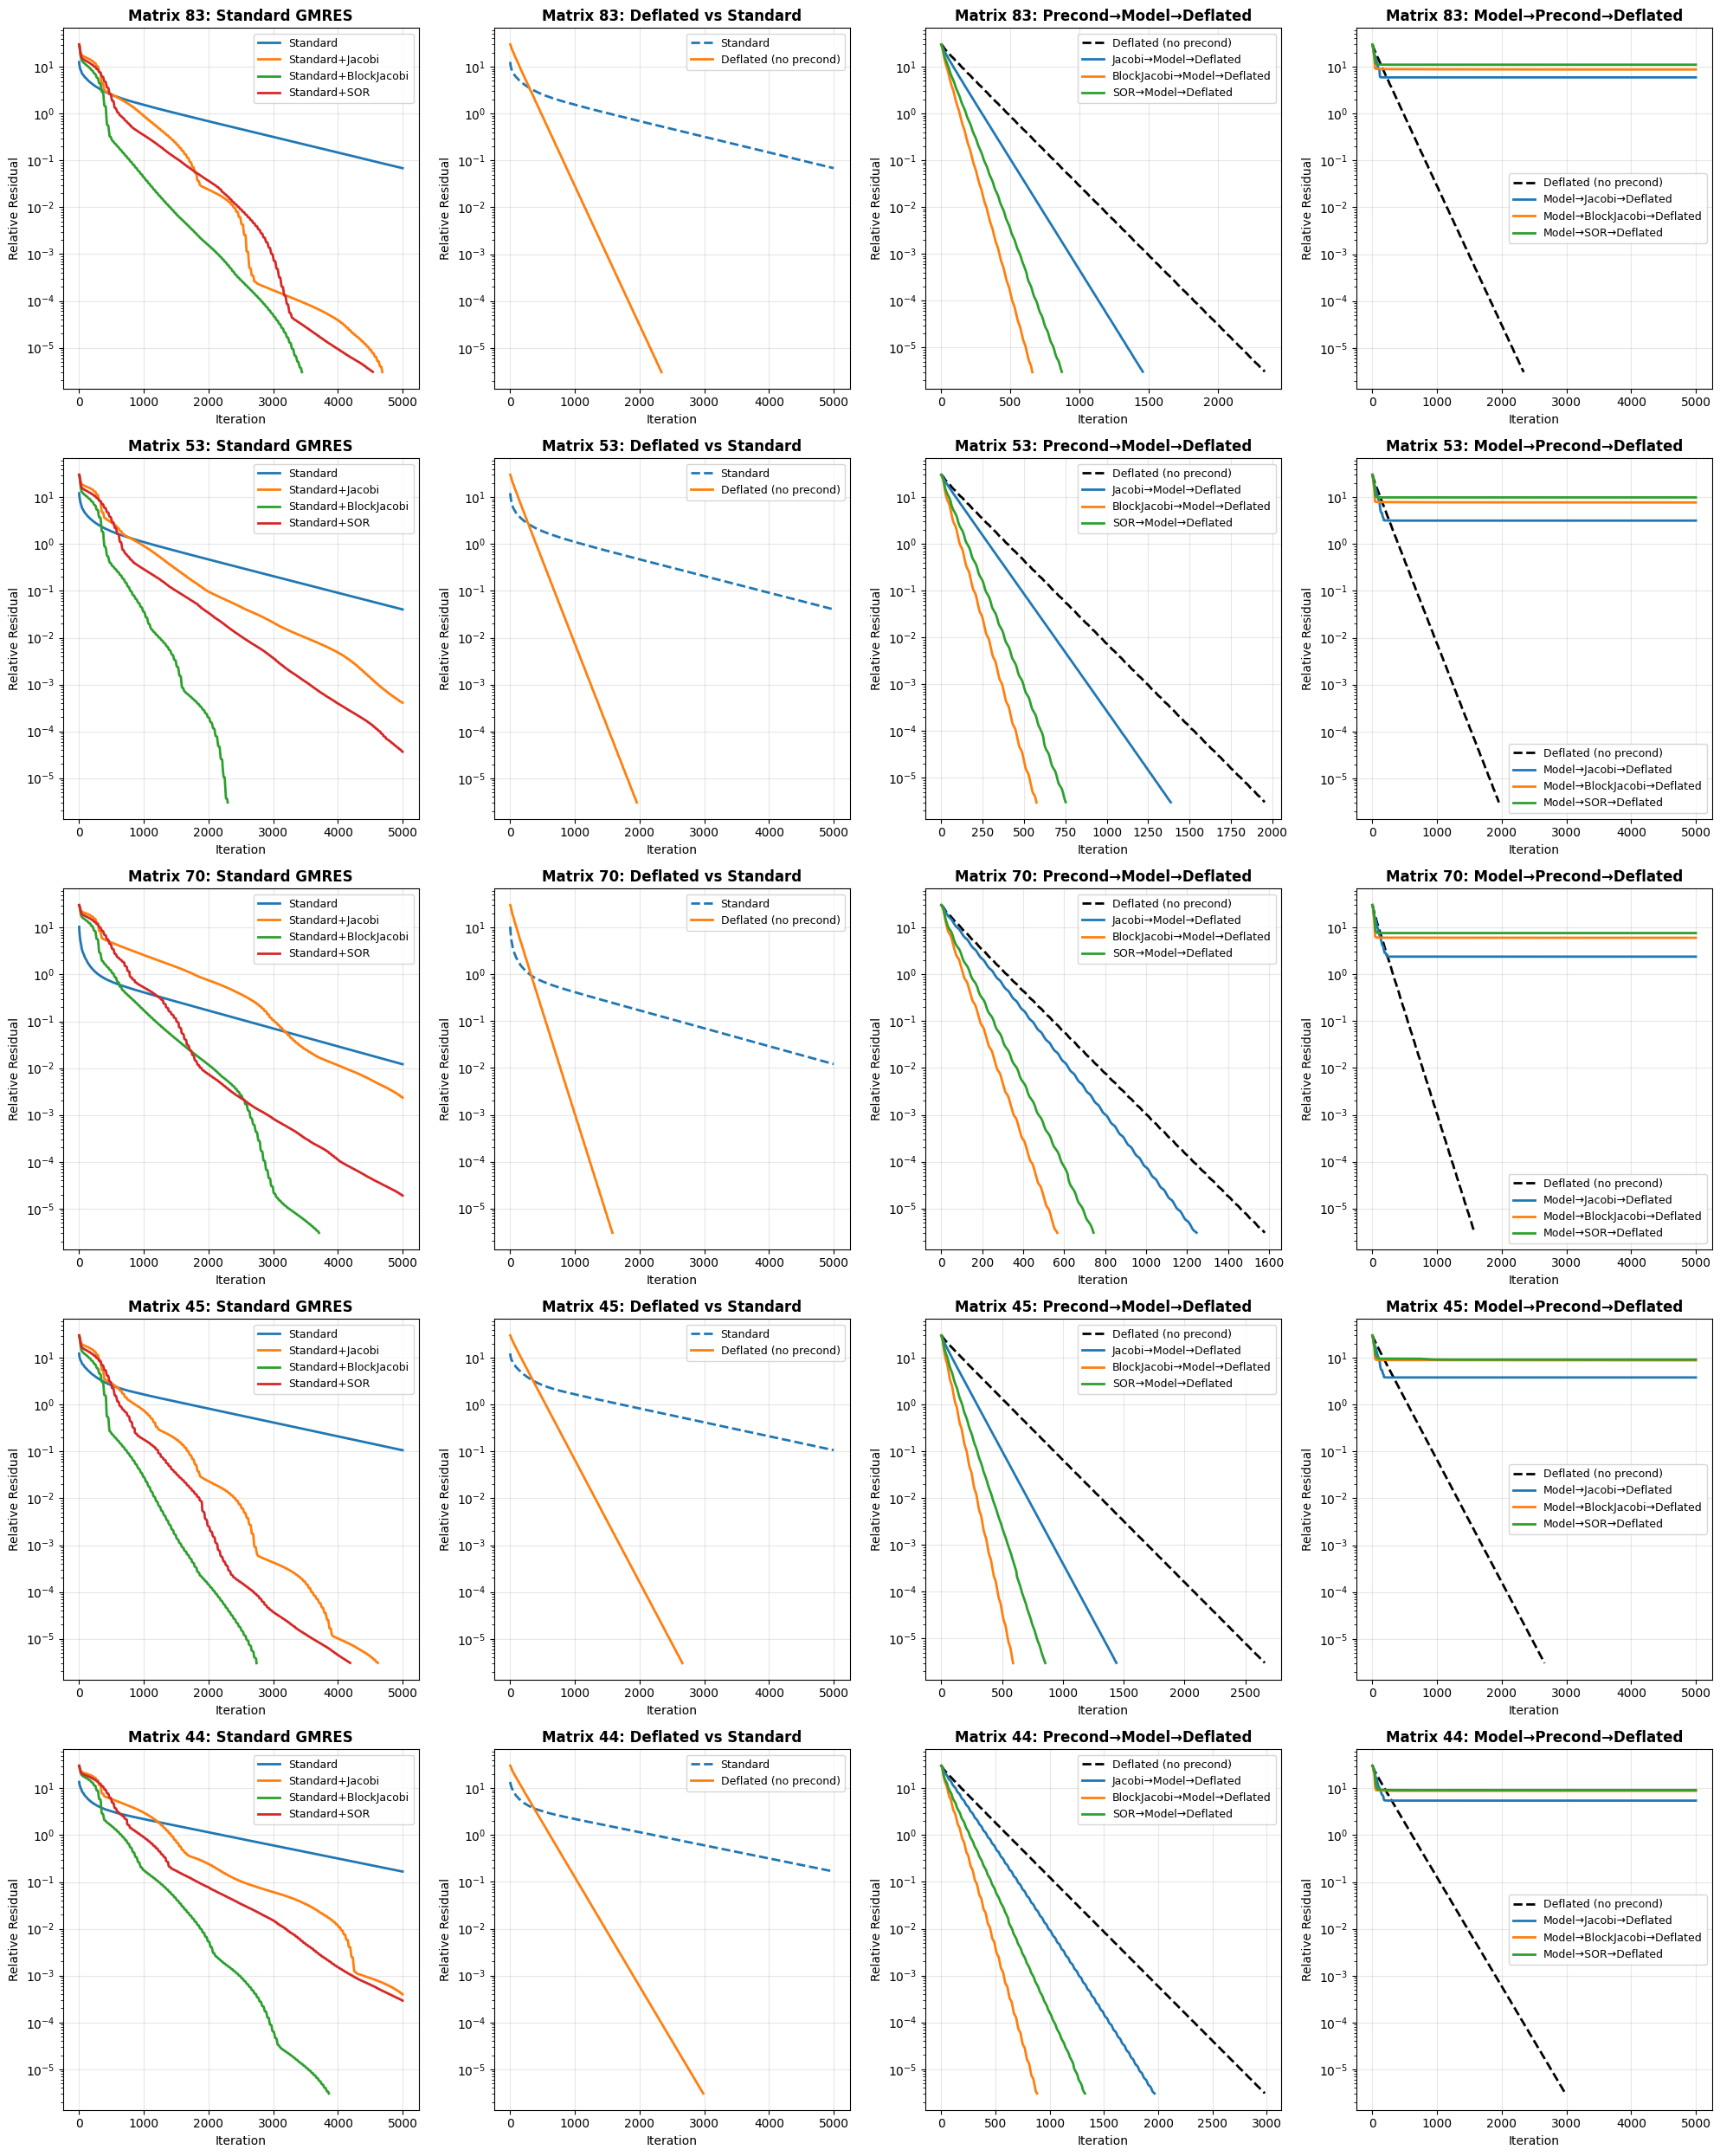

✓ Results saved to deflated_precond_results.csv

SUMMARY STATISTICS
                           speedup_time                      speedup_iters  \
                                   mean    std    min    max          mean   
method                                                                       
BlockJacobi→Model→Deflated        0.976  0.201  0.676  1.128         7.840   
Deflated                          1.693  0.502  1.215  2.507         2.283   
Jacobi→Model→Deflated             2.089  0.314  1.620  2.389         3.411   
Model→BlockJacobi→Deflated        0.129  0.008  0.122  0.142         1.000   
Model→Jacobi→Deflated             0.697  0.046  0.625  0.740         1.000   
Model→SOR→Deflated                0.140  0.012  0.129  0.157         1.000   
SOR→Model→Deflated                0.801  0.181  0.502  0.942         5.741   
Standard                          1.000  0.000  1.000  1.000         1.000   
Standard+BlockJacobi              0.220  0.060  0.166  0.303         1.619

In [27]:
# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Run pipeline
    results = main_pipeline(
        data_path="/content/drive/MyDrive/heat_backup/heat_batch_33.pt",
        model_path="./results/base_model.pt",
        num_tests=5,  # Adjust as needed
        tol=1e-7,
        maxiter=5000,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

In [34]:
def generate_summary_table(results_list: List[Dict]) -> pd.DataFrame:
    """
    Generate summary table showing averaged speedups across all matrices.
    Format matches the paper's table: speedup_time / speedup_iters
    """

    # Define comparisons for both strategies
    comparisons_precond_before = [
        ('Standard', 'Deflated', 'None'),
        ('Standard+Jacobi', 'Jacobi→Model→Deflated', 'Jacobi'),
        ('Standard+BlockJacobi', 'BlockJacobi→Model→Deflated', 'BJacobi'),
        ('Standard+SOR', 'SOR→Model→Deflated', 'SOR'),
    ]

    comparisons_precond_after = [
        ('Standard', 'Deflated', 'None'),
        ('Standard+Jacobi', 'Model→Jacobi→Deflated', 'Jacobi'),
        ('Standard+BlockJacobi', 'Model→BlockJacobi→Deflated', 'BJacobi'),
        ('Standard+SOR', 'Model→SOR→Deflated', 'SOR'),
    ]

    # Collect speedups for each comparison
    def compute_avg_speedups(comparisons):
        speedups = {name: {'time': [], 'iters': []} for _, _, name in comparisons}

        for results in results_list:
            methods = results['methods']
            for without, with_model, name in comparisons:
                if without in methods and with_model in methods:
                    time_speedup = methods[without]['time'] / methods[with_model]['time']
                    iter_speedup = methods[without]['iterations'] / methods[with_model]['iterations']
                    speedups[name]['time'].append(time_speedup)
                    speedups[name]['iters'].append(iter_speedup)

        # Average
        result = {}
        for name in speedups:
            if speedups[name]['time']:
                avg_time = np.mean(speedups[name]['time'])
                avg_iters = np.mean(speedups[name]['iters'])
                result[name] = f"{avg_time:.2f} / {avg_iters:.2f}"
            else:
                result[name] = "N/A"

        return result, speedups

    # Compute for both strategies
    precond_before, speedups_before = compute_avg_speedups(comparisons_precond_before)
    precond_after, speedups_after = compute_avg_speedups(comparisons_precond_after)

    # Compute slowdown: Model→Precond vs Precond→Model
    slowdown = {}
    method_names = ['None', 'Jacobi', 'BJacobi', 'SOR']
    method_map = {
        'None': 'Deflated',
        'Jacobi': 'Jacobi→Model→Deflated',
        'BJacobi': 'BlockJacobi→Model→Deflated',
        'SOR': 'SOR→Model→Deflated'
    }
    method_map_after = {
        'None': 'Deflated',
        'Jacobi': 'Model→Jacobi→Deflated',
        'BJacobi': 'Model→BlockJacobi→Deflated',
        'SOR': 'Model→SOR→Deflated'
    }

    for name in method_names:
        time_ratios = []
        iter_ratios = []

        for results in results_list:
            methods = results['methods']
            before_method = method_map[name]
            after_method = method_map_after[name]

            if before_method in methods and after_method in methods:
                time_ratio = methods[after_method]['time'] / methods[before_method]['time']
                iter_ratio = methods[after_method]['iterations'] / methods[before_method]['iterations']
                time_ratios.append(time_ratio)
                iter_ratios.append(iter_ratio)

        if time_ratios:
            slowdown[name] = f"{np.mean(time_ratios):.2f} / {np.mean(iter_ratios):.2f}"
        else:
            slowdown[name] = "N/A"

    # Create DataFrame
    data = {
        'Strategy': ['Precond→Model', 'Model→Precond', 'Slowdown (After/Before)'],
        'None': [precond_before['None'], precond_after['None'], slowdown['None']],
        'Jacobi': [precond_before['Jacobi'], precond_after['Jacobi'], slowdown['Jacobi']],
        'BJacobi': [precond_before['BJacobi'], precond_after['BJacobi'], slowdown['BJacobi']],
        'SOR': [precond_before['SOR'], precond_after['SOR'], slowdown['SOR']],
    }

    df = pd.DataFrame(data)
    return df


def print_summary_table(results_list: List[Dict]):
    """Print clean summary table."""
    df = generate_summary_table(results_list)

    print("\n" + "="*80)
    print("SUMMARY TABLE: Average Speedup (Time / Iterations)")
    print("="*80)
    print("\nFormat: time_speedup / iteration_speedup")
    print("Averaged across all test matrices\n")

    # Print table
    print(df.to_string(index=False))

    print("\nNote: Slowdown > 1.0 means Model→Precond is slower than Precond→Model")
    print("="*80)

    # Save to CSV
    df.to_csv('summary_table.csv', index=False)
    print("\n✓ Table saved to 'summary_table.csv'")

    return df


In [35]:
summary_df = print_summary_table(results)


SUMMARY TABLE: Average Speedup (Time / Iterations)

Format: time_speedup / iteration_speedup
Averaged across all test matrices

               Strategy        None      Jacobi     BJacobi         SOR
          Precond→Model 1.69 / 2.28 2.16 / 3.31 4.56 / 4.95 4.96 / 5.45
          Model→Precond 1.69 / 2.28 0.72 / 0.97 0.61 / 0.64 0.87 / 0.95
Slowdown (After/Before) 1.00 / 1.00 2.99 / 3.41 7.56 / 7.84 5.68 / 5.74

Note: Slowdown > 1.0 means Model→Precond is slower than Precond→Model

✓ Table saved to 'summary_table.csv'
